# Environment Preparation

## Imports

In [272]:
#handle and plot
import pandas            as pd
import numpy             as np
import seaborn           as sns
import scikitplot        as skplt
import matplotlib.pyplot as plt

#display
from tabulate               import tabulate
from IPython.core.display   import HTML
from IPython.display        import Image

#preparation and machine learning
from sklearn import preprocessing   as pp
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn import linear_model    as lm

# metrics

# handle pickle objects
import pickle

## Path Handlers

In [4]:
datapath = '../data/'
imagepath = '../images/'

## Helper Functions


In [5]:
def jupyter_settings():
    """ Otimiza configurações gerais, padronizanod tamanhos de plots, etc """
    %matplotlib inline
    #%pylab inline - not recommended
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [14, 6]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

def psycopg_connect():
    """"" Creates a psycopg connection from file postgre_credentials """""
    conn = pg.connect(    user = pg_user,
                          password = pg_passwd,
                          host = pg_host,
                          port = pg_port,
                          database = pg_db)
    return conn

# Data Collection


with sqlalchemy - works like a charm, for all dbs

with Psycopg2 - works as well, just for postgreSQL

## With sqlalchemy

In [ ]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from postgre_credentials import *

In [ ]:
# load from file postgre_credentials
url = 'postgresql://'+pg_user+':'+pg_passwd+'@'+pg_host+':'+pg_port+'/'+pg_db+''

if not database_exists(url):
    #create_database(url)
    print ("database does not exist!")
engine = create_engine(url, pool_size=50, echo=False)

In [ ]:
#connected:
#engine.url

In [ ]:
#select distinct schemas
query = "SELECT distinct(table_schema) from information_schema.tables"
df = pd.read_sql( query, engine )
df.head(500)

In [ ]:
#select tables from schema
query = "SELECT * FROM information_schema.tables WHERE table_schema = 'pa004'"
df = pd.read_sql( query, engine )
df.head(500)


In [ ]:
query = """SELECT * FROM pa004.insurance """
df = pd.read_sql( query, engine )
df.head()

In [ ]:
query = """SELECT * FROM pa004.vehicle """
df = pd.read_sql( query, engine )
df.head()

In [ ]:
query = """SELECT * FROM pa004.insurance """
df = pd.read_sql( query, engine )
df.head()

In [ ]:
#build raw dataset:
query = """

SELECT *
FROM pa004.users u 
INNER JOIN pa004.vehicle v on u.id = v.id 
INNER JOIN pa004.insurance i ON u.id = i.id
ORDER BY u.id

"""
df = pd.read_sql( query, engine )
df.head()

In [ ]:
# remove duplicate columns (i.e. the 'id' from vehicle and insurance tables)
df_raw = pd.read_sql( query, engine )
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
df_raw.head()

In [ ]:
df_raw.shape

In [ ]:
df_raw.to_csv(datapath+'data_collection_done.csv', index=False)

## With psycopg2

In [ ]:
import psycopg2 as pg
from postgre_credentials import *

In [ ]:
#Create connection, from Helper Funcions
conn = psycopg_connect()
#conn 

### Schema Query

In [ ]:
cursor = conn.cursor()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""
cursor.execute( query_schema )

record = cursor.fetchall()
cursor.close()
conn.close()

In [ ]:
record

### Table Query

In [ ]:
conn = psycopg_connect()
cursor = conn.cursor()

query_tables = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname='pa004'
"""
cursor.execute( query_tables )

record = cursor.fetchall()
print (record)
cursor.close() #important
conn.close() #important

### Collect Data using psycopg2 (just sample)

In [ ]:
conn = psycopg_connect()
cursor = conn.cursor()

query_table_users = """
    SELECT *
    FROM pa004.users u
    WHERE u.age > 44
    limit 10
"""
cursor.execute( query_table_users )

record = cursor.fetchall()
print (record)
cursor.close() #important
conn.close() #important

In [ ]:
data = pd.DataFrame( record )
data.head()
#would need to rename colums each time!

### Collect Data using Pandas

In [ ]:
conn = psycopg_connect()

#sample query
query_table_users = """
    SELECT *
    FROM pa004.users u
    WHERE u.age > 44
    limit 10
"""

df = pd.read_sql( query_table_users, conn )
df.head()

In [ ]:
#build raw dataset:
query_table_users = """
    SELECT *
    FROM pa004.users u 
    LEFT JOIN pa004.vehicle v ON u.id = v.id 
    LEFT JOIN pa004.insurance i ON u.id = i.id 
    ORDER BY u.id
"""

df = pd.read_sql( query_table_users, conn )
df.head()

In [ ]:
# remove duplicate columns (i.e. the 'id' from vehicle and insurance tables)
df_raw = pd.read_sql( query_table_users, conn )
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
df_raw.head()

In [ ]:
df_raw.shape

In [ ]:
#same result obtained with sqlarquemy, won't export again
#df_raw.to_csv(datapath+'data_collection_done.csv', index=False)

# Data Description

In [19]:
df1 = pd.read_csv(datapath+'data_collection_done.csv')
df1

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.0,26.0,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37.0,152.0,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30.0,160.0,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14.0,124.0,1,> 2 Years,Yes,0,44617.0,74,0


In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   driving_license       381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   previously_insured    381109 non-null  int64  
 9   annual_premium        381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## Rename Columns

In [21]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [22]:
df1 = df1.rename(columns={'previously_insured': 'vehicle_prev_insured',
                        'annual_premium': 'health_annual_paid',
                        'vintage': 'days_associated'})
df1

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.0,26.0,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37.0,152.0,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30.0,160.0,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14.0,124.0,1,> 2 Years,Yes,0,44617.0,74,0


## Column Meanings

In [23]:
#Double check understanding of each column

tab_meanings = [['Column', 'Meaning'],
    #####################################################  
        ['id', 'unique customer identifier.'],
        ['gender', 'client gender: Male / Female.'],
        ['age', 'customer age.'],
        ['region_code', 'customer region code.'],
        ['policy_sales_channel', 'Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..'],
        ['driving_license', '0 = customer does not have DL, 1 = already have DL'],
        ['vehicle_age', 'vehicle age: < 1 Year, 1-2 Year, > 2 Years'],
        ['vehicle_damage', 'No = customer has never had their vehicle damaged in the past, Yes = has had it.'],
        ['vehicle_prev_insured', '0 = customer does not have vehicle insurance, 1= already has vehicle insurance.'],
        ['health_annual_premium', 'annual amount paid by the customer to the company for health insurance. Currency: Rs(Pakistani rupee, R$1.00 = ± Rs0.03).'],
       
        ['days_associated', 'number of days since the customer joined the company by purchasing health insurance. The policy is annual.'],
        ['response', '0 = customer is not interested, 1 = customer is interested.']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='pipe'))
#tablefmt='pipe', tablefmt='grid'

| Column                | Meaning                                                                                                                   |
|:----------------------|:--------------------------------------------------------------------------------------------------------------------------|
| id                    | unique customer identifier.                                                                                               |
| gender                | client gender: Male / Female.                                                                                             |
| age                   | customer age.                                                                                                             |
| region_code           | customer region code.                                                                                                     |
| policy_sales_channel  | Anonymized Code for the channel of outreaching to the customer. Ie: Over M

## Data Dimension

In [24]:
print(f'Number of rows: {df1.shape[0]} ')
print(f'Number of columns: {df1.shape[1]} ')

Number of rows: 381109 
Number of columns: 12 


## Data Types

In [25]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
vehicle_prev_insured      int64
health_annual_paid      float64
days_associated           int64
response                  int64
dtype: object

In [26]:
df1

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.0,26.0,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37.0,152.0,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30.0,160.0,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14.0,124.0,1,> 2 Years,Yes,0,44617.0,74,0


In [27]:
#convert df['region_code'] to int:
#df['region_code'].value_counts()
df1['region_code'] = df1['region_code'].astype(int)
df1['region_code'].head()

0    28
1     3
2    28
3    11
4    41
Name: region_code, dtype: int64

In [28]:
#convert df['policy_sales_channel'] to int:
#df['policy_sales_channel'].value_counts().head(50)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
df1['policy_sales_channel'].head()


0     26
1     26
2     26
3    152
4    152
Name: policy_sales_channel, dtype: int64

In [29]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
vehicle_prev_insured      int64
health_annual_paid      float64
days_associated           int64
response                  int64
dtype: object

## Check NA

In [30]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
vehicle_prev_insured    0
health_annual_paid      0
days_associated         0
response                0
dtype: int64

## Fill NA

In [31]:
#Not necessary
pass

## Descriptive Statistical

In [32]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28,26,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,< 1 Year,No,1,27496.0,39,0


In [33]:
#separate cathegorical and numerical attributes
num_attributes = df1[['age','health_annual_paid','days_associated']]
cat_attributes = df1[['gender','region_code','policy_sales_channel','driving_license', 'vehicle_age', 'vehicle_damage', 'vehicle_prev_insured', 'response']]

In [34]:
num_attributes.sample(5)

,age,health_annual_paid,days_associated
190128,42,25034.0,185
306615,27,24915.0,74
132076,73,38904.0,168
102607,65,41066.0,241
161508,21,36572.0,180


In [35]:
cat_attributes.sample(5)

,gender,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,response
369686,Female,28,152,1,< 1 Year,No,1,0
354754,Female,15,26,1,1-2 Year,Yes,0,0
180129,Female,46,26,1,1-2 Year,No,1,0
38212,Female,28,152,1,< 1 Year,No,1,0
265143,Female,18,124,1,1-2 Year,Yes,0,0


### Numerical Attributes

In [36]:
#Central tendency metrics: mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion metrics: standard deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply ( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply ( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply ( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply ( lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [37]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,health_annual_paid,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,days_associated,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


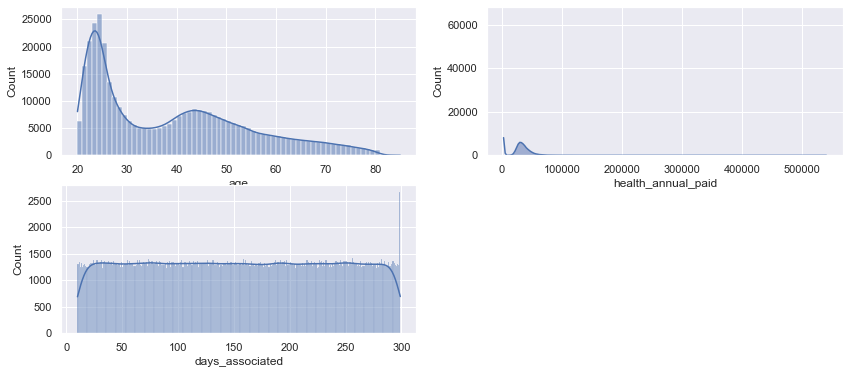

In [38]:
plt.subplot(2,2,1)
sns.histplot(df1['age'], binwidth=1, kde=True);
plt.subplot(2,2,2)
sns.histplot(df1['health_annual_paid'], kde=True);
plt.subplot(2,2,3)
sns.histplot(df1['days_associated'], binwidth=1, kde=True);

In [39]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,health_annual_paid,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,days_associated,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


Highlights:

age: mean = 36y, 1 std = 15.5  -->  68% of ages are between 20,5 and 51,5 y

health_annual_premium: very big range of 537535, high kurtosis, many extreme values.

days_associated: very uniform, probably will not help much.

### Cathegorical Attributes


In [40]:
#variations of each column
print( cat_attributes.apply( lambda x: x.unique() ) ,'\n')
print( cat_attributes.apply( lambda x: x.unique().shape[0] ) )

gender                                                     [Male, Female]
region_code             [28, 3, 11, 41, 33, 6, 35, 50, 15, 45, 8, 36, ...
policy_sales_channel    [26, 152, 160, 124, 14, 13, 30, 156, 163, 157,...
driving_license                                                    [1, 0]
vehicle_age                               [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                                                  [Yes, No]
vehicle_prev_insured                                               [0, 1]
response                                                           [1, 0]
dtype: object 

gender                    2
region_code              53
policy_sales_channel    155
driving_license           2
vehicle_age               3
vehicle_damage            2
vehicle_prev_insured      2
response                  2
dtype: int64


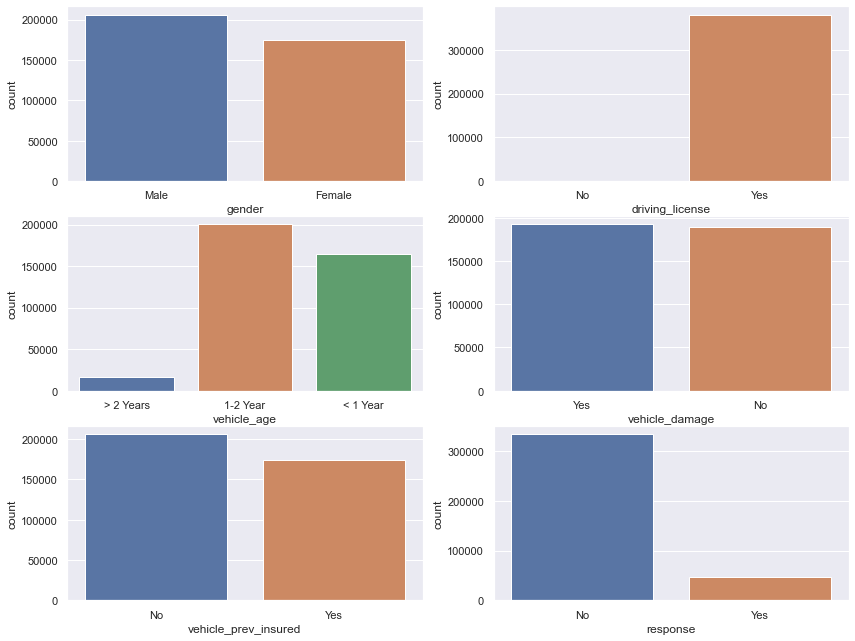

In [41]:
plt.subplots_adjust(top=1.5)

plt.subplot (3,2,1)
sns.countplot (x = cat_attributes['gender']);

plt.subplot (3,2,2)
sns.countplot (x = cat_attributes['driving_license']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,2,3)
sns.countplot (x = cat_attributes['vehicle_age']);

plt.subplot (3,2,4)
sns.countplot (x = cat_attributes['vehicle_damage']);

plt.subplot (3,2,5)
sns.countplot (x = cat_attributes['vehicle_prev_insured']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,2,6)
sns.countplot (x = cat_attributes['response']);
plt.xticks([0,1],['No','Yes']);

# uni_resp = sns.countplot(x = 'response', data = df3)
# uni_resp.set_ylabel('Number of customers')
# uni_resp.set_xlabel('Interested')
# uni_resp.set_xticklabels(['No', 'Yes']);
# uni_resp.set_title('Customers interest in vehicle insurance');

In [42]:
round(cat_attributes['response'].value_counts(normalize=True) *100 ,2)

0    87.74
1    12.26
Name: response, dtype: float64

Highlights:

- 12% of customers answered to be interested in a vehicle insurance.



In [43]:
#save dataset 
df1.to_csv(datapath+'data_description_done.csv', index=False)

# Feature Engeneering

In [106]:
df2 = pd.read_csv(datapath+'data_description_done.csv')
df2

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28,26,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26,26,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37,152,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30,160,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14,124,1,> 2 Years,Yes,0,44617.0,74,0


## Hypotheses mindmap

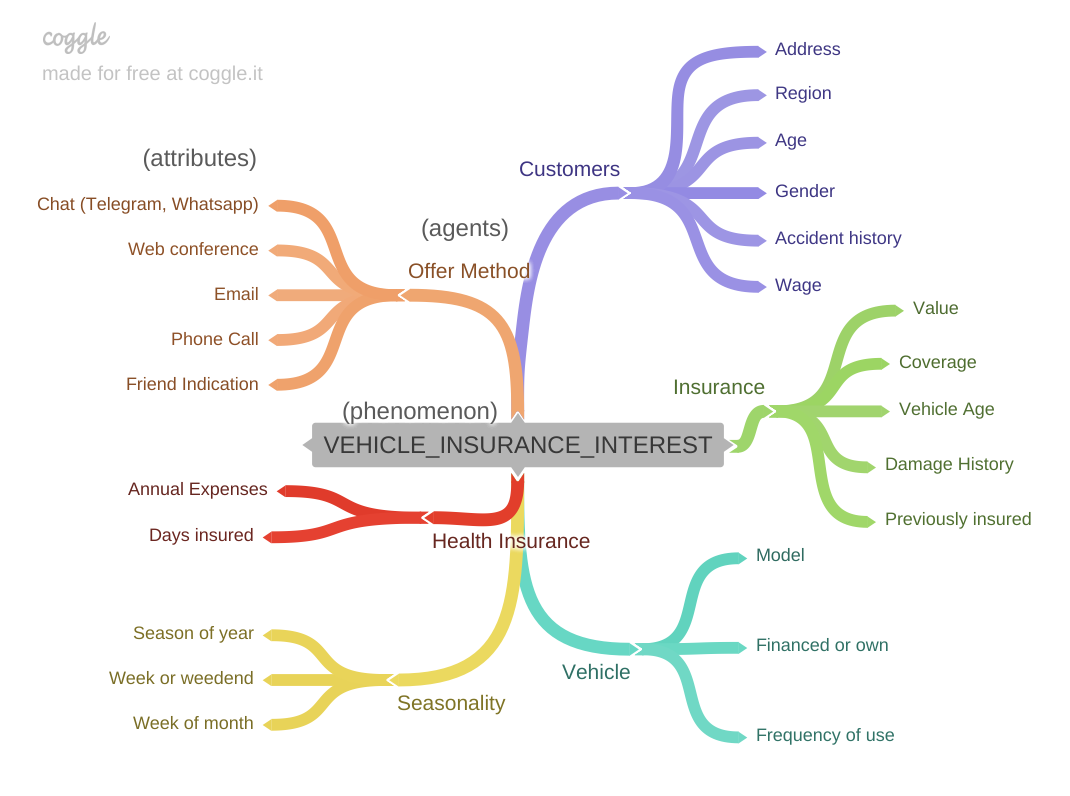

In [107]:
#hypotheses mindmap
Image( imagepath+'mindmap_hypotheses.png' )

## Hypotheses creation

In [108]:
#Created hypotheses with available dataset data
tab_hyp = [['ID', 'Hypotheses'],
################################################################################
        ['H1', 'Customers with AGE HIGHER should be MORE interested.'],
        ['H2', 'Customers with GENDER FEMALE should be MORE interested.'],
        ['H3', 'Customers of CERTAINS REGION should be MORE interested.'],
        ['H4', 'Customers of CERTAIN POLICY SALES CHANEL should be MORE interested.'],
        ['H5', 'Customers with MOST RECENT VEHICLE AGE should be MORE interested.'],
        ['H6', 'Customers who HAD VEHICLE DAMAGE should be MORE interested.'],
        ['H7', 'Customers who HAD VEHICLE PREVIOUSLY INSURED should be MORE interested.'],
        ['H8', 'Customers with HIGHER ANNUAL HEALTH EXPANSES should be MORE interested.'],
        ['H9', 'Customers whth MORE DAYS ASSOCIATED should be MORE interested.']]
################################################################################
print(tabulate(tab_hyp, headers='firstrow', stralign='left', tablefmt='pipe')) #tablefmt='pipe', tablefmt='grid'

| ID   | Hypotheses                                                              |
|:-----|:------------------------------------------------------------------------|
| H1   | Customers with AGE HIGHER should be MORE interested.                    |
| H2   | Customers with GENDER FEMALE should be MORE interested.                 |
| H3   | Customers of CERTAINS REGION should be MORE interested.                 |
| H4   | Customers of CERTAIN POLICY SALES CHANEL should be MORE interested.     |
| H5   | Customers with MOST RECENT VEHICLE AGE should be MORE interested.       |
| H6   | Customers who HAD VEHICLE DAMAGE should be MORE interested.             |
| H7   | Customers who HAD VEHICLE PREVIOUSLY INSURED should be MORE interested. |
| H8   | Customers with HIGHER ANNUAL HEALTH EXPANSES should be MORE interested. |
| H9   | Customers whth MORE DAYS ASSOCIATED should be MORE interested.          |


## Hypotheses priorization

In [109]:
#All hypotheses can be analysed on first CRISP cycle
pass

## Feature engeneering


In [110]:
df2['vehicle_age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: vehicle_age, dtype: int64

In [111]:
dict_vehicle_age = { '> 2 Years':'over_2_years', '1-2 Year':'between_1_2_years', '< 1 Year': 'below_1_year' }
df2['vehicle_age'] = df2['vehicle_age'].map(dict_vehicle_age)
df2['vehicle_age'].value_counts()

between_1_2_years    200316
below_1_year         164786
over_2_years          16007
Name: vehicle_age, dtype: int64

In [112]:
df2['vehicle_damage'].value_counts()

Yes    192413
No     188696
Name: vehicle_damage, dtype: int64

In [113]:
dict_vehicle_age = {'Yes': 1, 'No':0}
df2['vehicle_damage'] = df2['vehicle_damage'].map(dict_vehicle_age)
df2['vehicle_damage'].value_counts()

1    192413
0    188696
Name: vehicle_damage, dtype: int64

In [114]:
df2.to_csv(datapath+'feature_engeneering_done.csv', index=False)

# Variable Filtering



In [57]:
#no business related data evaluated as needed to exclude looking at Data Description
pass

# Exploratory Data Analysis


In [116]:
df3 = pd.read_csv(datapath+'feature_engeneering_done.csv')
df3

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,1,over_2_years,1,0,40454.0,217,1
1,2,Male,76,3,26,1,between_1_2_years,0,0,33536.0,183,0
2,3,Male,47,28,26,1,over_2_years,1,0,38294.0,27,1
3,4,Male,21,11,152,1,below_1_year,0,1,28619.0,203,0
4,5,Female,29,41,152,1,below_1_year,0,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26,26,1,between_1_2_years,0,1,30170.0,88,0
381105,381106,Male,30,37,152,1,below_1_year,0,1,40016.0,131,0
381106,381107,Male,21,30,160,1,below_1_year,0,1,35118.0,161,0
381107,381108,Female,68,14,124,1,over_2_years,1,0,44617.0,74,0


Good features in a Classification Project have a natural separation. 
The model aims to discover a cut in space to separate two classes.

## Univariate Analysis


In [64]:
#The analysis done in Descriptive Statistical is enough.
pass

## Bivariate analysis (insights pending)

1 - Relevance Estimate: Estimate if analyzing variable vs answer variable, data is separated or not into specific groups. Tabulate each variable relevance, to use in Feature Selection later.


2 - Validate each hypothesis and generate business insights. Tabulate data to present to business team.  

## Estimated Relevance

### Numeric Attributes

In [102]:
num_attributes.head()

,age,health_annual_paid,days_associated
0,44,40454.0,217
1,76,33536.0,183
2,47,38294.0,27
3,21,28619.0,203
4,29,27496.0,39


#### age

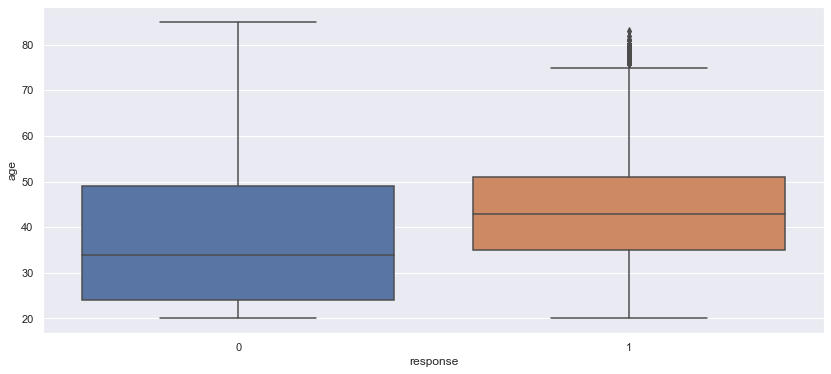

In [7]:
sns.boxplot( x='response', y='age', data=df3);

There is a difference between both distributions, looks like age can be useful to separate the data.

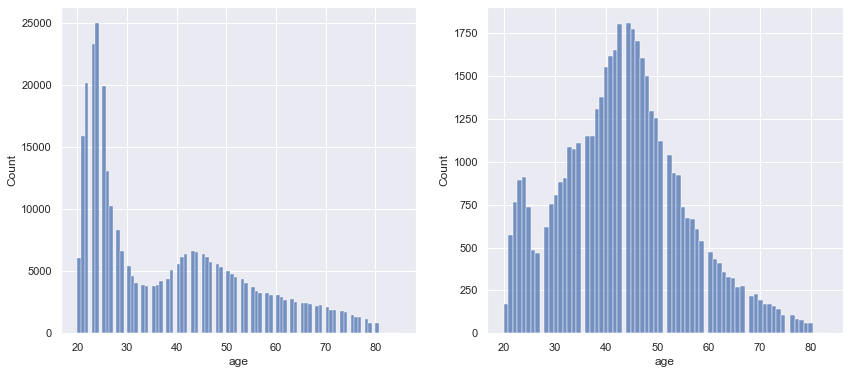

In [8]:
plt.subplot(1,2,1)
aux_age = df3.loc[df3['response'] == 0, 'age']
sns.histplot( aux_age );

plt.subplot(1,2,2)
aux_age2 = df3.loc[df3['response'] == 1, 'age']
sns.histplot( aux_age2 );

Amplitude analysis:

Left: There is a growth in response = 'no' arround 23, and between 40-50. 

Right: In response = 'yes', between 40-50 also there is a growth.

There is much less data with response = 1, in comparison to response = 0. This is an alert, cause I have much more the phenomenon represented in response = no than in response = yes.

#### health_annual_paid


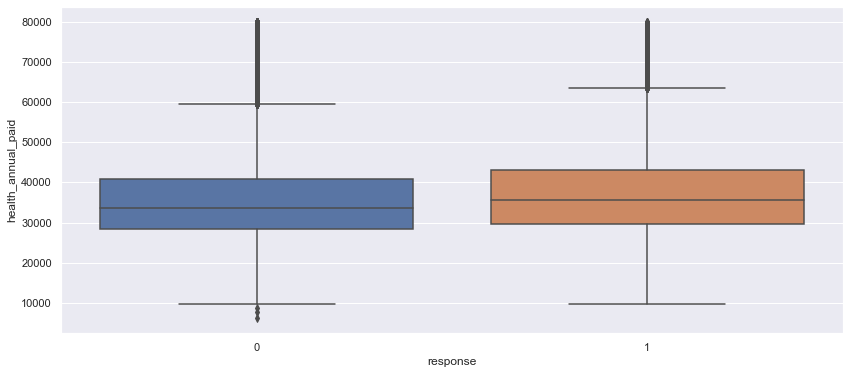

In [11]:
#There are many outliers, so let's remove them to make it clear: 
aux_hap = df3[ (df3['health_annual_paid'] > 5000) & (df3['health_annual_paid'] < 80000) ]
sns.boxplot( x='response', y='health_annual_paid', data=aux_hap);

Both distribution are very similar, median of interested and not intetested are almost the same, interquartile range too. 

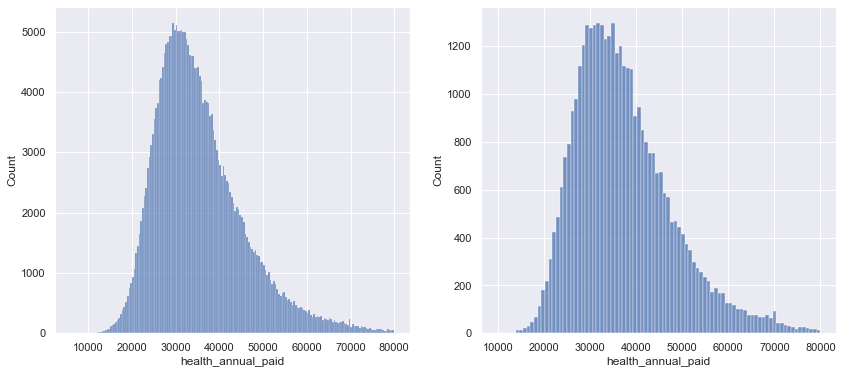

In [12]:
#Check distribution of interested / not interested:
plt.subplot(1,2,1)
aux_hap_n = aux_hap.loc[aux_hap['response'] == 0, 'health_annual_paid']
sns.histplot( aux_hap_n );

plt.subplot(1,2,2)
aux_hap_y = aux_hap.loc[aux_hap['response'] == 1, 'health_annual_paid']
sns.histplot( aux_hap_y );

Distribution is quite similar.
Alone, health_annual_paid does not seem to help separating the data. Maybe combinated with other data.

#### days_associated

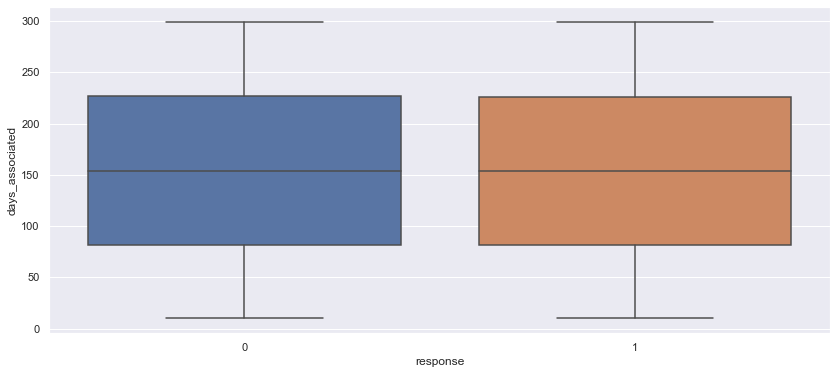

In [124]:
sns.boxplot( x='response', y='days_associated', data=df3);

Both shapes are pretty similar, medians are quite the same. 

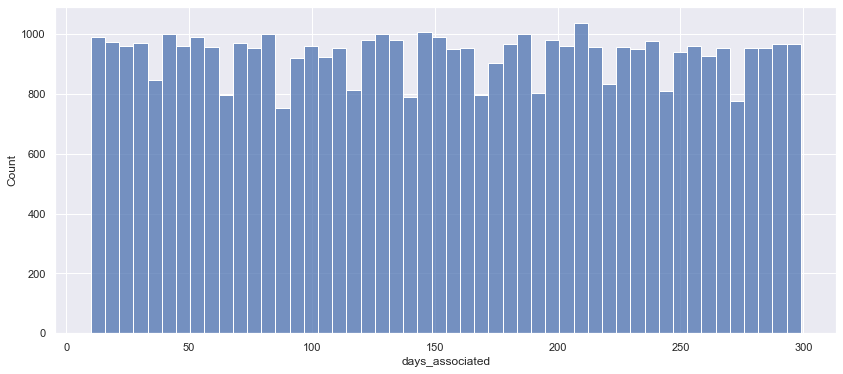

In [125]:
#just those who are interested
aux_d_yes = df3.loc[df3['response'] == 1, 'days_associated']
sns.histplot( aux_d_yes, bins=50 );

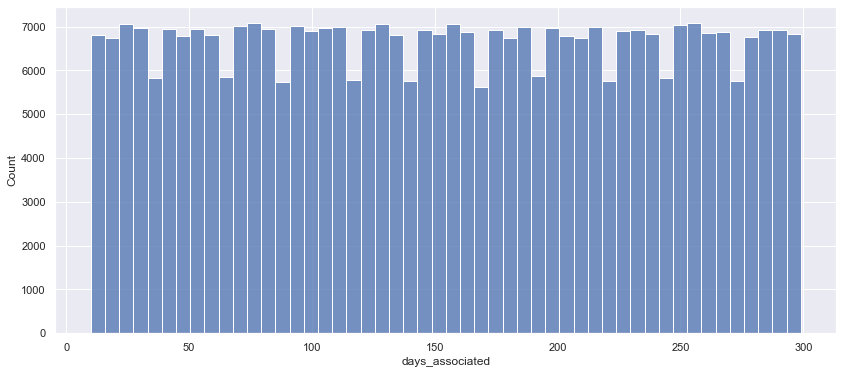

In [126]:
#just those who are Not interested
aux_d_no = df3.loc[df3['response'] == 0, 'days_associated']
sns.histplot( aux_d_no ,bins=50 );

Alone, 'days_associated' seems not help at all.

### Cathegorical Attributes

In [154]:
cat_attributes.sample(5)

,gender,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,response
237128,Female,28,26,1,1-2 Year,No,1,0
101161,Female,7,21,1,1-2 Year,Yes,0,1
329852,Male,48,26,1,1-2 Year,No,1,0
291247,Male,8,152,1,< 1 Year,No,1,0
324926,Female,37,160,1,< 1 Year,Yes,1,0


#### gender


In [133]:
round( pd.crosstab( df3['gender'], df3['response'],normalize='index') ,2)

response,0,1
gender,,
Female,0.90,0.10
Male,0.86,0.14


There are more male customers interested, but it is a subtle difference. Probably gender will not help much. 

#### region_code

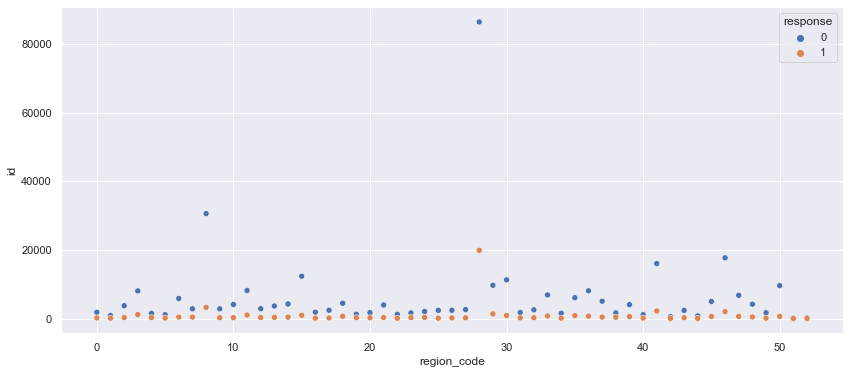

In [197]:
#There are 52 region codes. Use scatterplot to see if there are groups formed.
aux_reg = df3[['id', 'region_code', 'response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux_reg);

There is a region (28) who has a different behavior, much more data, but in general al others are mixed.


region_code alone seems not to help much to separate data. Maybe with other variables combined.  

#### policy_sales_channel

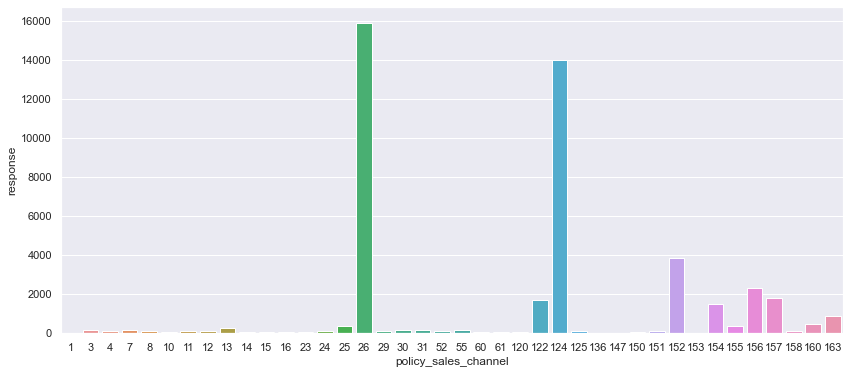

In [123]:
#Filter just those who are interested
aux_pol = df3[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
#Filter channels with more than 30 answers
aux_pol2 = aux_pol.loc[aux_pol['response'] > 30]
sns.barplot (x='policy_sales_channel', y='response', data=aux_pol2);

Interested customers are scattered into few channels, so it should help the model.

#### driving_license

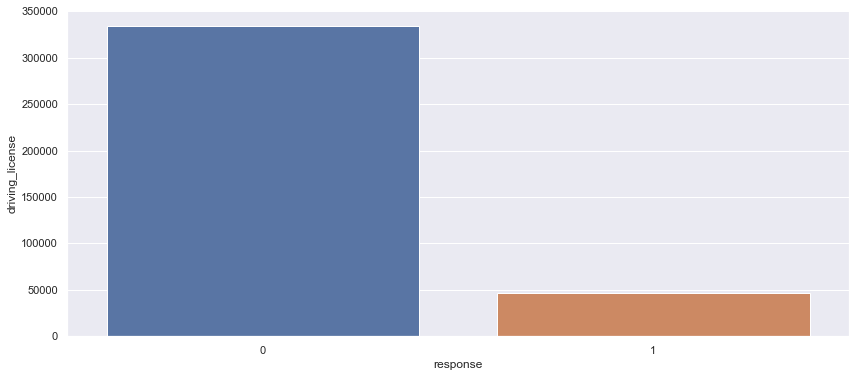

In [13]:
#Show all customers (with or withoud drivers license) by interest.
aux_drive = df3[['driving_license','response']].groupby('response').count().reset_index()
sns.barplot( x='response', y='driving_license', data=aux_drive);

In [218]:
#Contingency table to cross variables
round( pd.crosstab( df3['driving_license'], df3['response'] , normalize=True) ,3) #True = across entire df.

response,0,1
driving_license,,
0,0.002,0.000
1,0.875,0.122


99.7% of customers have drivers licence. 

Hence almost all customers have DL, this variable alone looks dispensable. Maybe combined can bring something.

#### vehicle_age

In [121]:
round( pd.crosstab( df3['vehicle_age'], df3['response'],normalize=True) ,2)
#below_1_year      - 41% no, 2% yes. (helps model)
#between_1_2_years - 43% no, 9% yes  (helps model)
#over_2_years      - 3% no, 1% yes   (confuse model)

response,0,1
vehicle_age,,
below_1_year,0.41,0.02
between_1_2_years,0.43,0.09
over_2_years,0.03,0.01


#### vehicle_damage

In [140]:
pd.crosstab( df3['vehicle_damage'], df3['response'] )

response,0,1
vehicle_damage,,
0,187714,982
1,146685,45728


In [144]:
round (pd.crosstab( df3['vehicle_damage'], df3['response'],normalize='index') ,2)

response,0,1
vehicle_damage,,
0,0.99,0.01
1,0.76,0.24


Less than 1% of customers who did not have damage are interested. -> Data leak risk.

#### vehicle_prev_insured

In [69]:
#Interested or not per vehicle_prev_insured
pd.crosstab( df3['vehicle_prev_insured'], df3['response'] )

response,0,1
vehicle_prev_insured,,
0,159929,46552
1,174470,158


In [71]:
# % of Interested or not per vehicle_prev_insured
round( pd.crosstab( df3['vehicle_prev_insured'], df3['response'], normalize='index' ) ,3)

response,0,1
vehicle_prev_insured,,
0,0.775,0.225
1,0.999,0.001


Less than 1% of customers with vehicle previously insured have interest (0.001%, or 158 customers of 174470). -> Data leak risk here.

22% of customers without vehicle previously insured have interest.


In [ ]:
TESTES

In [252]:
df3['gender'].value_counts()

Male      206089
Female    175020
Name: gender, dtype: int64

In [253]:
df3['response'].value_counts()

0    334399
1     46710
Name: response, dtype: int64

In [244]:
pd.crosstab( df3['gender'], df3['response'])

response,0,1
gender,,
Female,156835,18185
Male,177564,28525


In [276]:
pd.crosstab( df3['gender'], df3['response'],normalize=True) #'columns' = normalizes across cols, 'index' across rows, 'all' across entire df.

response,0,1
gender,,
Female,0.411523,0.047716
Male,0.465914,0.074847


### Estimated Relevance

In [156]:
#Estimated relevance of variables to the model  
tab_var_relev = [['Variable', 'Estimated Relevance', 'Justification'],
    #####################################################  
        #numeric
        ['age', 'High','well separated data'], #ok
        ['health_annual_paid', 'None','very similar data'], #ok
        ['days_associated', 'None','very similar data'],#ok
        #cathegoric      
        ['gender', 'Low',' there are subtle differences'],#ok
        ['region_code', 'None',' very similar data'],#ok
        ['policy_sales_channel', 'Medium','some few channels have interested groups'], #ok
        ['driving_license', 'None',' 99.7% has DL'], #ok
        ['vehicle_age', 'Medium',' 2 value grups are well separated, one is not'], #ok
        ['vehicle_damage', 'None (??) ',' -> (see if Meigarom used, data leak risk. I would\'t use.)'],
        ['vehicle_prev_insured', 'None (??) ',' -> (see if Meigarom used, data leak risk. I would\'t use.)'] 
      ]
print(tabulate(tab_var_relev, headers='firstrow', stralign='left', tablefmt='pipe'))
#tablefmt='pipe', tablefmt='grid'

| Variable             | Estimated Relevance   | Justification                                             |
|:---------------------|:----------------------|:----------------------------------------------------------|
| age                  | High                  | well separated data                                       |
| health_annual_paid   | None                  | very similar data                                         |
| days_associated      | None                  | very similar data                                         |
| gender               | Low                   | there are subtle differences                              |
| region_code          | None                  | very similar data                                         |
| policy_sales_channel | Medium                | some few channels have interested groups                  |
| driving_license      | None                  | 99.7% has DL                                              |
| vehicle_age      

#### Hypotheses (pending)



In [159]:
#List of Hypotheses
print(tabulate(tab_hyp, headers='firstrow', stralign='left', tablefmt='pipe'))

| ID   | Hypotheses                                                              |
|:-----|:------------------------------------------------------------------------|
| H1   | Customers with AGE HIGHER should be MORE interested.                    |
| H2   | Customers with GENDER FEMALE should be MORE interested.                 |
| H3   | Customers of CERTAINS REGION should be MORE interested.                 |
| H4   | Customers of CERTAIN POLICY SALES CHANEL should be MORE interested.     |
| H5   | Customers with MOST RECENT VEHICLE AGE should be MORE interested.       |
| H6   | Customers who HAD VEHICLE DAMAGE should be MORE interested.             |
| H7   | Customers who HAD VEHICLE PREVIOUSLY INSURED should be MORE interested. |
| H8   | Customers with HIGHER ANNUAL HEALTH EXPANSES should be MORE interested. |
| H9   | Customers whth MORE DAYS ASSOCIATED should be MORE interested.          |


# Data Preparation


In [281]:
df4 = pd.read_csv(datapath+'feature_engeneering_done.csv')
df4

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,1,over_2_years,1,0,40454.0,217,1
1,2,Male,76,3,26,1,between_1_2_years,0,0,33536.0,183,0
2,3,Male,47,28,26,1,over_2_years,1,0,38294.0,27,1
3,4,Male,21,11,152,1,below_1_year,0,1,28619.0,203,0
4,5,Female,29,41,152,1,below_1_year,0,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26,26,1,between_1_2_years,0,1,30170.0,88,0
381105,381106,Male,30,37,152,1,below_1_year,0,1,40016.0,131,0
381106,381107,Male,21,30,160,1,below_1_year,0,1,35118.0,161,0
381107,381108,Female,68,14,124,1,over_2_years,1,0,44617.0,74,0


## Split Dataset

Split full dataset into training and validation.

In [282]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split (X, y, test_size=0.20)

df4 = pd.concat( [x_train, y_train], axis=1 ) 

In [283]:
df4

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
200294,200295,Male,27,41,152,1,below_1_year,0,0,36037.0,104,0
237409,237410,Female,25,30,152,1,below_1_year,0,1,20198.0,279,0
14859,14860,Male,32,28,124,1,between_1_2_years,0,1,30606.0,45,0
49408,49409,Female,22,7,160,1,below_1_year,0,0,32768.0,148,0
29622,29623,Male,29,30,152,1,below_1_year,0,1,36111.0,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...
85139,85140,Female,68,28,24,1,between_1_2_years,0,1,25690.0,183,0
278484,278485,Male,30,28,154,1,below_1_year,1,0,33636.0,32,0
344567,344568,Male,44,46,124,1,between_1_2_years,1,0,26946.0,263,1
260192,260193,Female,24,17,124,1,between_1_2_years,1,1,36825.0,264,0


## Standardization

For numeric vars with normal distribution

### health_annual_paid

It has normal distribution since filtered as done previously: health_annual_paid > 5000 and < 80000.
Values outside this range could be removed if considered outliers, but it is not clear if they are.
Let's standardise them in 1st crisp cycle then now, and review on 2nd.

In [284]:
#StandardScaler
ss = pp.StandardScaler()
df4['health_annual_paid'] = ss.fit_transform( df4[['health_annual_paid']].values )

## Rescaling


For numeric vars with NOT normal distribution

### age

In [285]:
# MinMaxScaler (few outliers)
mms_age = pp.MinMaxScaler()
df4['age'] = mms_age.fit_transform( df4[['age']].values )

### days_associated

In [286]:
# MinMaxScaler (few outliers)
mms_days_assoc = pp.MinMaxScaler()
df4['days_associated'] = mms_days_assoc.fit_transform( df4[['days_associated']].values )

## Encoding

Transform categorical variables into numeric

### gender

In [287]:
#one hot encoder / target encoder
#Lets use target encoder
target_encode_gender = df4.groupby('gender')['response'].mean()
df4.loc[:,'gender'] = df4['gender'].map(target_encode_gender)

### driving_license

In [288]:
#It's already label encoded (0 and 1)
df4['driving_license'].value_counts()

1    304231
0       656
Name: driving_license, dtype: int64

### region_code

In [289]:
# frequency encoding / target encoding / weighted target encoding
# Lets use target encoding
target_encode_region_code = df4.groupby('region_code')['response'].mean()
df4.loc[:,'region_code'] = df4['region_code'].map(target_encode_region_code)

### vehicle_prev_insured

In [290]:
#It's already label encoded (0 and 1)
df4['vehicle_prev_insured'].value_counts()

0    165137
1    139750
Name: vehicle_prev_insured, dtype: int64

### vehicle_age

In [291]:
#one hot encoding / Label Encoding / frequency encoding
# Lets use one hot encoding
df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )

### vehicle_damage

In [292]:
#It's already label encoded (0 and 1)
df4['vehicle_damage'].value_counts()

1    153916
0    150971
Name: vehicle_damage, dtype: int64

### policy_sales_channel

In [293]:
#frequency encoding / target encoding
# Lets use frequency encoding
fe_policy_sales_chanel = df4.groupby('policy_sales_channel').size() / len (df4)
df4.loc[:,'policy_sales_channel'] = df4['policy_sales_channel'].map(fe_policy_sales_chanel)

In [294]:
df4

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
200294,200295,0.138608,0.107692,0.121751,0.353800,1,0,0,0.316228,0.325260,0,1,0,0
237409,237410,0.103670,0.076923,0.074294,0.353800,1,0,1,-0.600759,0.930796,0,1,0,0
14859,14860,0.138608,0.184615,0.186806,0.193928,1,0,1,0.001804,0.121107,0,0,1,0
49408,49409,0.103670,0.030769,0.137434,0.056919,1,0,0,0.126972,0.477509,0,1,0,0
29622,29623,0.138608,0.138462,0.074294,0.353800,1,0,1,0.320512,0.058824,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85139,85140,0.103670,0.738462,0.186806,0.001942,1,0,1,-0.282804,0.598616,0,0,1,0
278484,278485,0.138608,0.153846,0.186806,0.015655,1,1,0,0.177224,0.076125,0,1,0,0
344567,344568,0.138608,0.369231,0.103311,0.193928,1,1,0,-0.210089,0.875433,1,0,1,0
260192,260193,0.103670,0.061538,0.070522,0.193928,1,1,1,0.361849,0.878893,0,0,1,0


## Validation Preparation

Prepare validation data with same transformations of training 

In [295]:
#gender
x_val.loc[:,'gender'] = x_val.loc[:, 'gender'].map( target_encode_gender )
#age
x_val.loc[:,'age'] = mms_age.fit_transform( x_val[['age']].values )
#region_code
x_val.loc[:,'region_code'] = x_val.loc[:,'region_code'].map(target_encode_region_code)
#policy_sales_channel
x_val.loc[:,'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_chanel)
#driving_license
    #not needed
#vehicle_age
x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )
#vehicle_damage
    #not needed
#vehicle_prev_insured
    #not needed
#health_annual_paid
x_val.loc[:, 'health_annual_paid'] = ss.fit_transform( x_val[['health_annual_paid']].values )
#days_associated
x_val.loc[:, 'days_associated'] = mms_days_assoc.fit_transform( x_val[['days_associated']].values )

/Users/home/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/home/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/home/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a co

In [296]:
x_val.isna().sum()

id                               0
gender                           0
age                              0
region_code                      0
policy_sales_channel             2
driving_license                  0
vehicle_damage                   0
vehicle_prev_insured             0
health_annual_paid               0
days_associated                  0
vehicle_age_below_1_year         0
vehicle_age_between_1_2_years    0
vehicle_age_over_2_years         0
dtype: int64

In [298]:
#fillna
    #needed because there are 2 policies from policy_sales_channel on test that is not on training (even separating randomly).
x_val = x_val.fillna(0)

In [300]:
x_val

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
327705,327706,0.103670,0.676923,0.103311,0.209146,1,1,0,0.174133,0.145329,0,1,0
1422,1423,0.103670,0.107692,0.072424,0.353800,1,1,0,0.135540,0.076125,1,0,0
106985,106986,0.103670,0.046154,0.074294,0.353800,1,0,1,-0.044933,0.287197,1,0,0
59547,59548,0.103670,0.507692,0.186806,0.209146,1,1,0,1.348477,0.885813,0,1,0
147492,147493,0.103670,0.830769,0.186806,0.209146,1,1,0,1.207421,0.055363,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218901,218902,0.103670,0.153846,0.121751,0.353800,1,0,1,0.199705,0.186851,1,0,0
282847,282848,0.138608,0.553846,0.112216,0.193928,1,0,1,0.346122,0.276817,0,1,0
156621,156622,0.103670,0.353846,0.186806,0.209146,1,0,0,0.150506,0.778547,0,1,0
113230,113231,0.138608,0.492308,0.072424,0.027938,1,1,0,-1.643445,0.782007,0,1,0


In [301]:
df4.to_csv(datapath+'data_prep_train_done.csv', index=False) #contains x_train + y_train

# Feature Selection

In [302]:
df5 = pd.read_csv(datapath+'data_prep_train_done.csv')
df5

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
0,200295,0.138608,0.107692,0.121751,0.353800,1,0,0,0.316228,0.325260,0,1,0,0
1,237410,0.103670,0.076923,0.074294,0.353800,1,0,1,-0.600759,0.930796,0,1,0,0
2,14860,0.138608,0.184615,0.186806,0.193928,1,0,1,0.001804,0.121107,0,0,1,0
3,49409,0.103670,0.030769,0.137434,0.056919,1,0,0,0.126972,0.477509,0,1,0,0
4,29623,0.138608,0.138462,0.074294,0.353800,1,0,1,0.320512,0.058824,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304882,85140,0.103670,0.738462,0.186806,0.001942,1,0,1,-0.282804,0.598616,0,0,1,0
304883,278485,0.138608,0.153846,0.186806,0.015655,1,1,0,0.177224,0.076125,0,1,0,0
304884,344568,0.138608,0.369231,0.103311,0.193928,1,1,0,-0.210089,0.875433,1,0,1,0
304885,260193,0.103670,0.061538,0.070522,0.193928,1,1,1,0.361849,0.878893,0,0,1,0


## Boruta


In [ ]:
# Implement (will select just 1 or 2 features)
pass

## Extra Trees

Lets use Extra Trees to find features importance. Could be a RandomForest, XGBoost, etc

In [303]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id','response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                         feature  importance
0                days_associated    0.272161
0             health_annual_paid    0.244339
0                            age    0.164167
0                    region_code    0.106709
0                 vehicle_damage    0.067393
0           policy_sales_channel    0.059549
0           vehicle_prev_insured    0.056933
0       vehicle_age_below_1_year    0.014146
0  vehicle_age_between_1_2_years    0.006941
0                         gender    0.004936
0       vehicle_age_over_2_years    0.002209
0                driving_license    0.000517


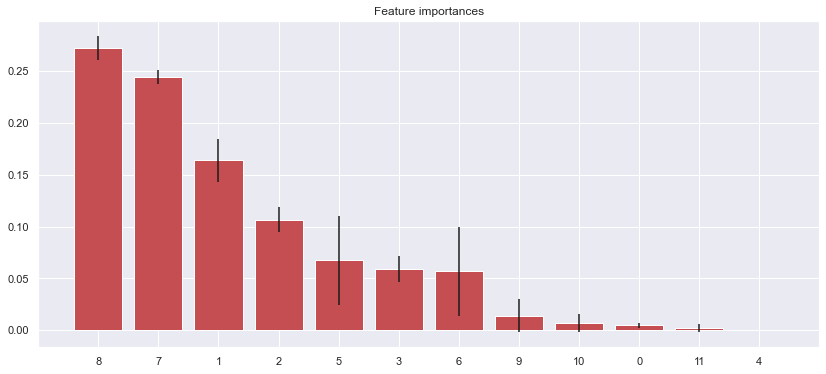

In [305]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort(importances)[::-1] #trees importance ordered by greater value

# Print feature ranking
print('Feature Ranking:')
df_imp = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature':i , 'importance': j}, index=[0] )
    df_imp = pd.concat( [df_imp, aux], axis=0 )
    
print(df_imp.sort_values('importance', ascending=False) )

# Plot the imputity-based feature importances os the forest
plt.figure()
plt.title('Feature importances')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_n.shape[1]), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

In [306]:
df_imp

,feature,importance
0,gender,0.004936
0,age,0.164167
0,region_code,0.106709
0,policy_sales_channel,0.059549
0,driving_license,0.000517
0,vehicle_damage,0.067393
0,vehicle_prev_insured,0.056933
0,health_annual_paid,0.244339
0,days_associated,0.272161
0,vehicle_age_below_1_year,0.014146


# Machine Learning

Select features up to 5% of importance (7 first)

In [307]:
x_val

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
327705,327706,0.103670,0.676923,0.103311,0.209146,1,1,0,0.174133,0.145329,0,1,0
1422,1423,0.103670,0.107692,0.072424,0.353800,1,1,0,0.135540,0.076125,1,0,0
106985,106986,0.103670,0.046154,0.074294,0.353800,1,0,1,-0.044933,0.287197,1,0,0
59547,59548,0.103670,0.507692,0.186806,0.209146,1,1,0,1.348477,0.885813,0,1,0
147492,147493,0.103670,0.830769,0.186806,0.209146,1,1,0,1.207421,0.055363,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218901,218902,0.103670,0.153846,0.121751,0.353800,1,0,1,0.199705,0.186851,1,0,0
282847,282848,0.138608,0.553846,0.112216,0.193928,1,0,1,0.346122,0.276817,0,1,0
156621,156622,0.103670,0.353846,0.186806,0.209146,1,0,0,0.150506,0.778547,0,1,0
113230,113231,0.138608,0.492308,0.072424,0.027938,1,1,0,-1.643445,0.782007,0,1,0


In [308]:
cols_selected = ['days_associated','health_annual_paid','age','region_code',
                 'vehicle_damage','policy_sales_channel', 'vehicle_prev_insured']

x_train = df4[ cols_selected ]
x_val_with_id = x_val.copy() #will be used in model performance
x_val = x_val[ cols_selected ]

In [311]:
x_val_with_id

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
327705,327706,0.103670,0.676923,0.103311,0.209146,1,1,0,0.174133,0.145329,0,1,0
1422,1423,0.103670,0.107692,0.072424,0.353800,1,1,0,0.135540,0.076125,1,0,0
106985,106986,0.103670,0.046154,0.074294,0.353800,1,0,1,-0.044933,0.287197,1,0,0
59547,59548,0.103670,0.507692,0.186806,0.209146,1,1,0,1.348477,0.885813,0,1,0
147492,147493,0.103670,0.830769,0.186806,0.209146,1,1,0,1.207421,0.055363,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218901,218902,0.103670,0.153846,0.121751,0.353800,1,0,1,0.199705,0.186851,1,0,0
282847,282848,0.138608,0.553846,0.112216,0.193928,1,0,1,0.346122,0.276817,0,1,0
156621,156622,0.103670,0.353846,0.186806,0.209146,1,0,0,0.150506,0.778547,0,1,0
113230,113231,0.138608,0.492308,0.072424,0.027938,1,1,0,-1.643445,0.782007,0,1,0


In [310]:
x_val

,days_associated,health_annual_paid,age,region_code,vehicle_damage,policy_sales_channel,vehicle_prev_insured
327705,0.145329,0.174133,0.676923,0.103311,1,0.209146,0
1422,0.076125,0.135540,0.107692,0.072424,1,0.353800,0
106985,0.287197,-0.044933,0.046154,0.074294,0,0.353800,1
59547,0.885813,1.348477,0.507692,0.186806,1,0.209146,0
147492,0.055363,1.207421,0.830769,0.186806,1,0.209146,0
...,...,...,...,...,...,...,...
218901,0.186851,0.199705,0.153846,0.121751,0,0.353800,1
282847,0.276817,0.346122,0.553846,0.112216,0,0.193928,1
156621,0.778547,0.150506,0.353846,0.186806,0,0.209146,0
113230,0.782007,-1.643445,0.492308,0.072424,1,0.027938,0


## KNN

In [312]:
# Model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=15 )

# Model training
knn_model.fit( x_train, y_train )

# Model prediction from validation data -> model learning power
yhat_knn = knn_model.predict_proba( x_val )

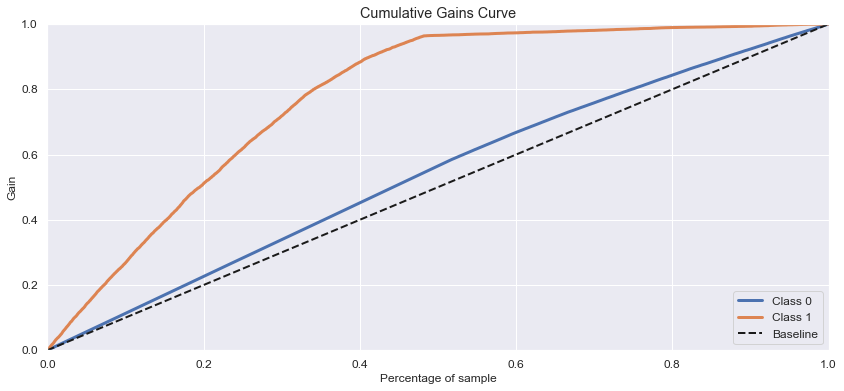

In [313]:
# Cumulative Gain
                                   #validation true responses, #validation prediction responses 
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

KNN -> approaching 48% of the sorted list, we reach 97% of interested.

## Logistic Regression

In [314]:
# Model definition
lr_model = lm.LogisticRegression( random_state=42 )

# Model training
lr_model.fit( x_train, y_train )

# Model prediction from validation data -> model learning power
yhat_lr = lr_model.predict_proba( x_val )

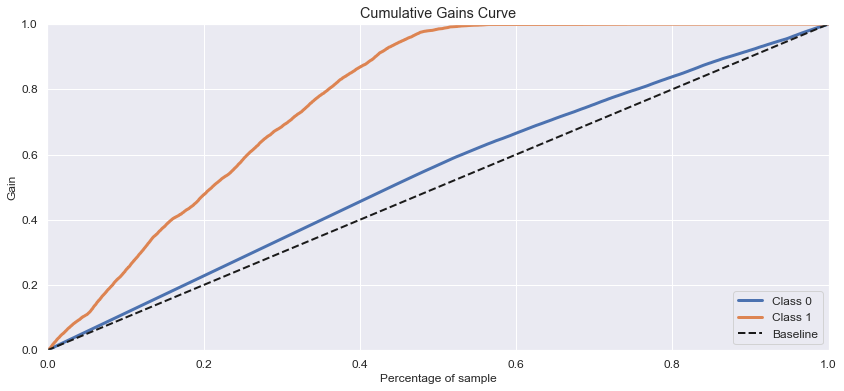

In [315]:
# Cumulative Gain
                                   #validation true responses, #validation prediction responses 
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

Logistic regression -> approaching 55% of the sorted list, we reach 100% of interested people

## Extra Trees

In [316]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, random_state=30, n_jobs=-1 )

# model fit
et.fit (x_train, y_train)

# model predict
yhat_et = et.predict_proba(x_val)

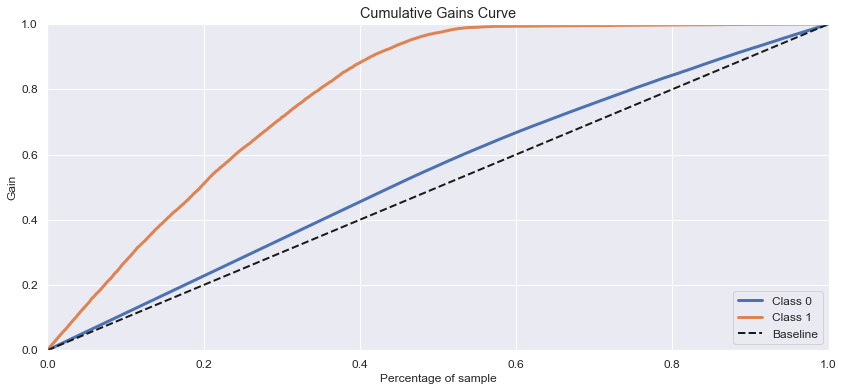

In [317]:
# Cumulative Gain
                                   #validation true responses, #validation prediction responses 
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

Extra Trees -> approaching 55% of the sorted list, we reach 99% of interested people

# Model Performance

KNN ->                 approaching 48% of the sorted list, we reach 97% of interested.
Logistic regression -> approaching 55% of the sorted list, we reach 100% of interested people
Extra Trees ->         approaching 55% of the sorted list, we reach 99% of interested people

In [347]:
# Retrieve dataset with id
df6 = x_val_with_id.copy()

In [348]:
df6

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
327705,327706,0.103670,0.676923,0.103311,0.209146,1,1,0,0.174133,0.145329,0,1,0
1422,1423,0.103670,0.107692,0.072424,0.353800,1,1,0,0.135540,0.076125,1,0,0
106985,106986,0.103670,0.046154,0.074294,0.353800,1,0,1,-0.044933,0.287197,1,0,0
59547,59548,0.103670,0.507692,0.186806,0.209146,1,1,0,1.348477,0.885813,0,1,0
147492,147493,0.103670,0.830769,0.186806,0.209146,1,1,0,1.207421,0.055363,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218901,218902,0.103670,0.153846,0.121751,0.353800,1,0,1,0.199705,0.186851,1,0,0
282847,282848,0.138608,0.553846,0.112216,0.193928,1,0,1,0.346122,0.276817,0,1,0
156621,156622,0.103670,0.353846,0.186806,0.209146,1,0,0,0.150506,0.778547,0,1,0
113230,113231,0.138608,0.492308,0.072424,0.027938,1,1,0,-1.643445,0.782007,0,1,0


### Precision Top K

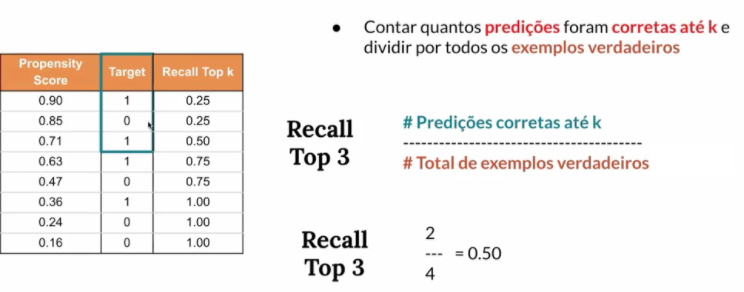

In [349]:
Image( imagepath+'precision_sample.png')

In [350]:
# Include real responses (Column Target)
df6['response'] = y_val.copy()

In [351]:
df6.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years,response
327705,327706,0.10367,0.676923,0.103311,0.209146,1,1,0,0.174133,0.145329,0,1,0,0
1422,1423,0.10367,0.107692,0.072424,0.353800,1,1,0,0.135540,0.076125,1,0,0,0
106985,106986,0.10367,0.046154,0.074294,0.353800,1,0,1,-0.044933,0.287197,1,0,0,0
59547,59548,0.10367,0.507692,0.186806,0.209146,1,1,0,1.348477,0.885813,0,1,0,1
147492,147493,0.10367,0.830769,0.186806,0.209146,1,1,0,1.207421,0.055363,0,1,0,0


In [352]:
# Create Propensity Score
                      # all rows of col 1, 
df6['score'] = yhat_knn[:,1].tolist()

# sort clients by propensity score
df6 = df6.sort_values('score', ascending=False)

In [353]:
df6

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years,response,score
158121,158122,0.138608,0.138462,0.074294,0.007632,1,1,0,-0.425323,0.328720,1,0,0,1,0.866667
265634,265635,0.103670,0.338462,0.186806,0.209146,1,1,0,0.732640,0.512111,0,1,0,1,0.866667
225225,225226,0.138608,0.153846,0.121751,0.209146,1,1,0,-0.191232,0.543253,0,1,0,0,0.800000
342122,342123,0.138608,0.261538,0.186806,0.193928,1,1,0,0.510746,0.716263,0,1,0,0,0.800000
354190,354191,0.138608,0.415385,0.186806,0.209146,1,1,0,0.931615,0.775087,0,1,0,0,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101512,101513,0.103670,0.138462,0.186806,0.027938,1,1,1,-1.643445,0.512111,0,1,0,0,0.000000
275962,275963,0.103670,0.061538,0.096688,0.353800,1,1,0,0.682499,0.269896,1,0,0,0,0.000000
356738,356739,0.138608,0.707692,0.186806,0.209146,1,0,1,0.812654,0.214533,0,1,0,0,0.000000
300214,300215,0.103670,0.430769,0.186806,0.193928,1,0,1,-0.185694,0.089965,0,1,0,0,0.000000


In [344]:
df6[['id','response','score']].head()

,id,response,score
0,267992,0,0.866667
1,97776,0,0.866667
2,340886,1,0.800000
3,127703,0,0.800000
4,113956,0,0.800000


In [362]:
# Create recall top k function
def precicion_at_k (data, k=2000):
    # reset index
    data = data.reset_index (drop=True)
    
    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']   

In [363]:
# Compute precision at k
precicion_at_50 = precicion_at_k (df6, k=50)
precicion_at_50

0.27450980392156865

In [366]:
# Create precision top k function
def recall_at_k (data, k=2000):
    # reset index
    data = data.reset_index (drop=True)
    
    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [367]:
# Compute recall at k
recall_at_50 = recall_at_k (df6, k=50)
recall_at_50

0.0014982876712328766

In [ ]:
df6[['id','response','score', 'ranking', 'precision_at_k']].head()
    

# Fine Tuning

# Improvements before production


-NUm and Cat Attibutes labels: iuclude coments
- EDA: include label and titles in columns on Variable Evaluation
uni_resp = sns.countplot(x = 'response', data = df3)
uni_resp.set_ylabel('Number of customers')
uni_resp.set_xlabel('Interested')
uni_resp.set_xticklabels(['No', 'Yes']);
uni_resp.set_title('Customers interest in vehicle insurance');

- EDA: cross region_code with vehicle_damage and with vehicle_prev_insured. Good results!
- EDA: include hyp part.
- Data preparation: investigate fill na from policy_sales_channel
- Feature selection: try with Boruta 

- Meigarom: testar usar embedding PCA pra esse problema, e aplicar knn ou árvore em cima dele, criar outras variáveis, tentar outros encoders, pra fazer a curva ficar mais ingrivem.


